In [31]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import geopandas as gpd
import requests
import zipfile
import re
import os
from io import BytesIO
import shapely
from shapely.wkt import loads
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
from sklearn import datasets
from sklearn import cluster
import statsmodels.formula.api as smf
import statsmodels.api as sm
from pysal.model import spreg
from libpysal import weights
from pysal.explore import esda


pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

# Import/Clean/Merge Data Frames

### Import LSOA data and removing unneeded columns

In [2]:
lsoa_df = pd.read_csv("data/UKCensus-21-11-London-21geog-data.csv") 
lsoa_gdf = gpd.GeoDataFrame(lsoa_df) 
lsoa_gdf['geometry'] = lsoa_gdf['geometry'].apply(lambda x: loads(x))
lsoa_gdf = lsoa_gdf.set_geometry('geometry')


dcolumns = ['FemRes21',
       'FemRes11_m21', 'MalRes21', 'MalRes11_m21', 'Asian21', 'Asian11_m21',
       'Black21', 'Black11_m21', 'MixedE21', 'MixedE11_m21', 'White21',
       'White11_m21', 'OtherE21', 'OtherE11_m21',
       'CarsZero11_m21', 'CarsOne21', 'CarsOne11_m21', 'CarsTwo21',
       'CarsTwo11_m21', 'CarsThrp21', 'CarsThrp11_m21','HealthVG21', 'HealthVG11_m21', 'HealthGood21',
       'HealthGood11_m21', 'HealthFair21', 'HealthFair11_m21', 'HealthBad21',
       'HealthBad11_m21', 'HealthVB21', 'HealthVB11_m21','EconSt11_m21','EconUn11_m21','QualNone11_m21','QualSch21', 'QualSch11_m21', 'QualUni21', 'QualUni11_m21', 'QualOt21']
lsoa_gdf = lsoa_gdf.drop(columns=dcolumns,axis=1)
lsoa_gdf['change'] = lsoa_gdf['CHGIND'] != 'U'


### Crime data from 2020 Dec to 2023 Nov

In [4]:
data_path = "data/2020_2023_crime"
for year in range(2020, 2024):
    for month in range(1, 13):
        date_folder = f"{year}-{month:02d}"
        folder_path = os.path.join(data_path, date_folder).replace("\\", "/")

        # Check if the folder exists
        if os.path.exists(folder_path):
            city_csv_path = os.path.join(folder_path, f"{date_folder}-city-of-london-street.csv").replace("\\", "/")
            metro_csv_path = os.path.join(folder_path, f"{date_folder}-metropolitan-street.csv").replace("\\", "/")
            city_df = pd.read_csv(city_csv_path, usecols=["LSOA code", "Crime type"])
            metro_df = pd.read_csv(metro_csv_path, usecols=["LSOA code", "Crime type"])
            city_df = city_df.dropna()
            metro_df = metro_df.dropna()
            city_burglary = city_df[city_df["Crime type"] == "Burglary"]
            metro_burglary = metro_df[metro_df["Crime type"] == "Burglary"]
            city_burglary_counts = city_burglary.groupby("LSOA code").size().reset_index(name="Count")
            metro_burglary_counts = metro_burglary.groupby("LSOA code").size().reset_index(name="Count")
            combined_burglary_counts = pd.merge(city_burglary_counts, metro_burglary_counts, on="LSOA code", how="outer", suffixes=('_city', '_metro'))
            combined_burglary_counts = combined_burglary_counts.fillna(0)
            combined_burglary_counts['Total_Count'] = combined_burglary_counts['Count_city'] + combined_burglary_counts['Count_metro']
            combined_burglary_counts = combined_burglary_counts.drop(['Count_city',"Count_metro"],axis=1)
                
            if 'new_df' in locals():
                new_df = new_df.merge(combined_burglary_counts,on="LSOA code", how="left", suffixes=("",'_new'))
                new_df = new_df.fillna(0)
                new_df['Total_Count'] = new_df['Total_Count'] + new_df['Total_Count_new']
                new_df = new_df.drop(["Total_Count_new"], axis=1)
            else:
                new_df = pd.DataFrame()
                new_df['LSOA code'] = lsoa_gdf['LSOA21CD'].copy()
                new_df = new_df.merge(combined_burglary_counts,on="LSOA code", how="left")
                new_df = new_df.fillna(0)

### Merge crime with LSOA data

In [5]:
crime_df = new_df
crime_df= crime_df.rename(columns= {"LSOA code":"LSOA21CD"})
gdf = lsoa_gdf.merge(crime_df, how='inner',on ='LSOA21CD')
gdf = gdf[~gdf['change']]

### Import HHI and Merge

In [6]:
hhi = pd.read_csv("data/LSOA_Data_2011.csv")
hhi.columns
hhi = hhi[['LSOA11CD', 'HHI_mean']]
hhi = hhi.rename(columns = {'LSOA11CD':'LSOA21CD'})
gdf = gdf.merge(hhi,how='inner',on = 'LSOA21CD')

### Import Homeownership and Merge

In [7]:
homeown = pd.read_csv("data/homeowner.csv")
homeown.head()
gdf=gdf.merge(homeown, how='inner', on = 'LSOA21CD')


# Create Variables - HHINC, HHOLDEN, HOMEOWN, UNEMPLY, NOVEHC, AGE

In [471]:
gdf= gdf.rename(columns={'Owed ourright' : 'HOMEOWN',"HHI_mean" : 'HHI', 'Total_Count':'BURG'})
gdf['POPDEN'] =( gdf['TotRes21']/gdf['LSOA21KM2'])
gdf['HHDEN'] = gdf['TotHHolds21']/(gdf['LSOA21KM2']*100)
gdf['UNEMPL'] = gdf['EconUn21']/(gdf['AgeAdult21'] + gdf['AgeSenior21'])
gdf['BURGCASE'] = gdf['BURG']/(gdf['LSOA21KM2']*100)
gdf['OWNHOME'] = gdf['HOMEOWN']/gdf['TotHHolds11_m21']

In [187]:
gdf.nlargest(20,'BURGCASE')[['LSOA21KM2','BURGCASE','LSOA21NM']]

LSOA21KM2  BURGCASE                     LSOA21NM
4451       0.09     13.91             Westminster 016B
4480       0.06     13.71             Westminster 017C
2636       0.07     13.68  Kensington and Chelsea 013D
4636       0.05     12.65             Westminster 009I
4639       0.09     12.63                 Hackney 030A
4484       0.12     12.26             Westminster 017F
4444       0.09     12.21             Westminster 005B
4483       0.09     11.66             Westminster 017E
4485       0.06     11.65             Westminster 016E
4494       0.29     11.54             Westminster 013B
3727       0.05     11.38               Southwark 006B
4404       0.09     11.34             Westminster 012E
4417       0.05     11.05             Westminster 017A
4640       0.11     10.99                 Hackney 030B
2896       0.08     10.94                 Lambeth 011F
823        0.15     10.73                  Camden 028D
4551       0.04     10.70               Southwark 035C
2633       0.07     10.67  Kensington and Chelsea 015B
4261       0.09     10.57           Tower Hamlets 015E
4501       0.12     10.23             Westminster 012A

In [193]:
gdf[ind_var].describe()

UNEMPL        HHI  OWNHOME    HHDEN    POPDEN
count 4,659.00   4,659.00 4,659.00 4,659.00  4,659.00
mean      0.04  50,638.64     0.22    39.49  9,960.66
std       0.01  14,726.91     0.13    26.74  6,095.20
min       0.01  31,490.00     0.00     0.42    119.89
25%       0.03  40,900.00     0.12    20.72  5,464.99
50%       0.04  47,150.00     0.21    33.03  8,823.53
75%       0.05  55,775.00     0.31    53.23 13,394.99
max       0.12 178,030.00     0.61   247.60 55,677.45

<Axes: >

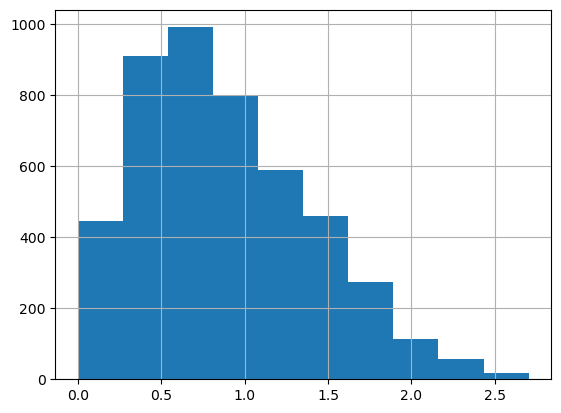

In [188]:
gdf['trans_burg'] = np.log(gdf['BURGCASE'] + 1)
gdf['trans_burg'].hist()

In [474]:
gdf['BURGCASE'].describe()


count   4,659.00
mean        1.82
std         1.77
min         0.00
25%         0.62
50%         1.23
75%         2.45
max        13.91
Name: BURGCASE, dtype: float64

# Figures

### Map showing Yes/No Change to 2011 LSOAs

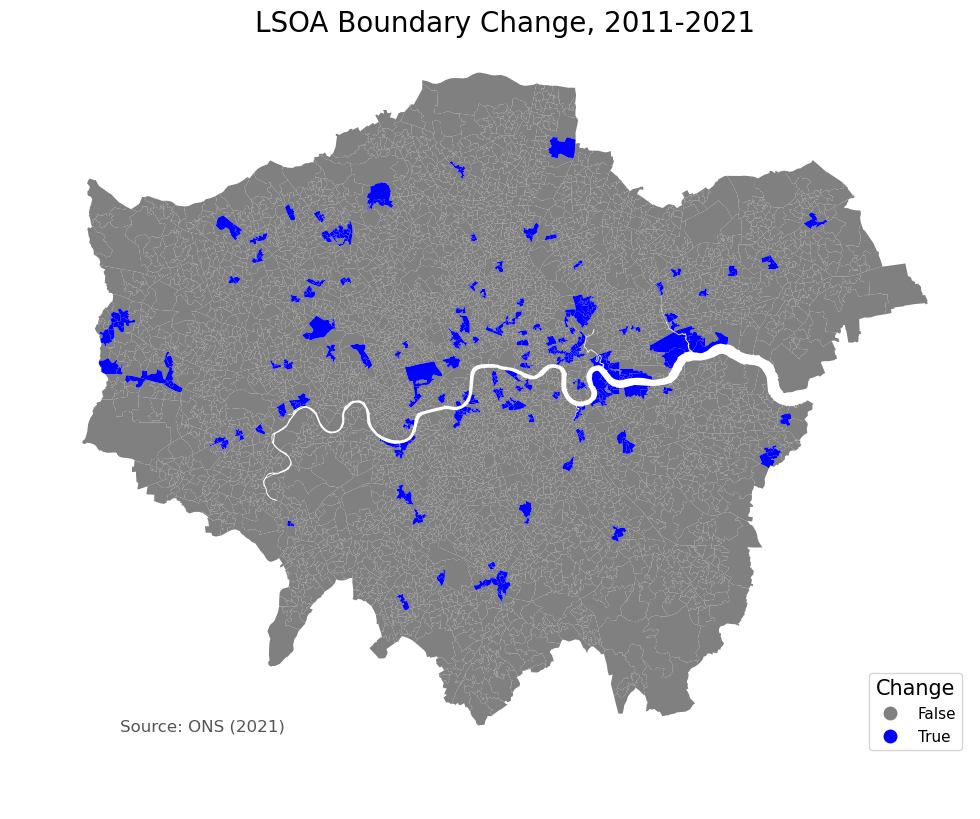

In [20]:
cmap = ListedColormap(['grey', 'blue'])
fig, ax1 = plt.subplots(1, figsize=(12, 10))   
lsoa_gdf.plot(column='change', ax=ax1, cmap=cmap,
         edgecolor='grey', linewidth=0.0,
         legend=True, legend_kwds={'title': "Change",
                                   'loc': 'lower right',
                                   'title_fontsize':15,
                                   'fontsize':11})  
ax1.axis('off')
plt.title('LSOA Boundary Change, 2011-2021', fontsize=20)
ax1.annotate('Source: ONS (2021)',
             xy=(0.1, 0.1), xycoords='figure fraction', 
             horizontalalignment='left', verticalalignment='top', 
             fontsize=12, color='#555555')

#plt.savefig("img/Map_LSOAs_BoundaryChg_11-21.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# OLS Model

In [472]:
ind_vars = ['UNEMPL','log_HHI','OWNHOME','HHDEN','POPDEN']
m1 = spreg.OLS(gdf[["log_BURGCASE"]].values,
    # Independent variables
    gdf[ind_vars].values,
    # Dependent variable name
    name_y="Burglary Cases",
    # Independent variable name
    name_x=ind_vars,)

print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :Burglary Cases                Number of Observations:        4659
Mean dependent var  :      0.8884                Number of Variables   :           6
S.D. dependent var  :      0.5154                Degrees of Freedom    :        4653
R-squared           :      0.6550
Adjusted R-squared  :      0.6546
Sum squared residual:     426.801                F-statistic           :   1766.8062
Sigma-square        :       0.092                Prob(F-statistic)     :           0
S.E. of regression  :       0.303                Log likelihood        :   -1042.774
Sigma-square ML     :       0.092                Akaike info criterion :    2097.549
S.E of regression ML:      0.3027                Schwarz criterion     :    2136.228

---------------------------------------------------------------------------

(array([1.000e+00, 2.000e+00, 1.000e+00, 6.000e+00, 7.000e+01, 9.470e+02,
        2.468e+03, 9.630e+02, 1.690e+02, 3.200e+01]),
 array([-2.50606516, -2.1235377 , -1.74101024, -1.35848277, -0.97595531,
        -0.59342785, -0.21090039,  0.17162707,  0.55415453,  0.936682  ,
         1.31920946]),
 <BarContainer object of 10 artists>)

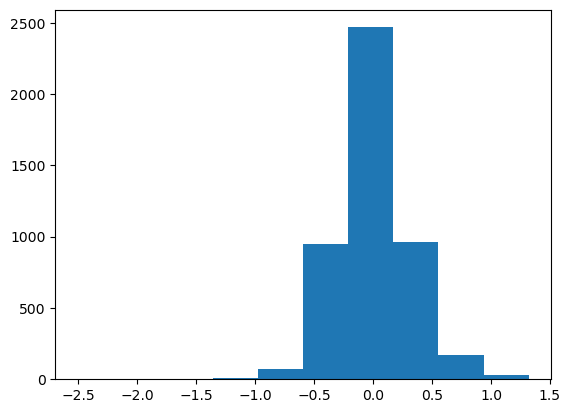

In [473]:
resid = m1.u
plt.hist(resid)

## Spatial Weight Matrix (Queen), Morans I for Burglary

In [425]:
w = weights.Queen.from_dataframe(gdf)
moran = esda.moran.Moran(gdf['log_BURGCASE'], w)

('WARNING: ', 4477, ' is an island (no neighbors)')
('WARNING: ', 4617, ' is an island (no neighbors)')


In [470]:
ind_vars = ['UNEMPL','log_HHI','OWNHOME','HHDEN','POPDEN']
m1 = spreg.OLS(gdf[["log_BURGCASE"]].values,gdf[ind_vars].values,name_y="Burglary Cases",name_x=ind_vars,)
print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :Burglary Cases                Number of Observations:        4659
Mean dependent var  :      0.8884                Number of Variables   :           6
S.D. dependent var  :      0.5154                Degrees of Freedom    :        4653
R-squared           :      0.6550
Adjusted R-squared  :      0.6546
Sum squared residual:     426.801                F-statistic           :   1766.8062
Sigma-square        :       0.092                Prob(F-statistic)     :           0
S.E. of regression  :       0.303                Log likelihood        :   -1042.774
Sigma-square ML     :       0.092                Akaike info criterion :    2097.549
S.E of regression ML:      0.3027                Schwarz criterion     :    2136.228

---------------------------------------------------------------------------

0.271
0.001


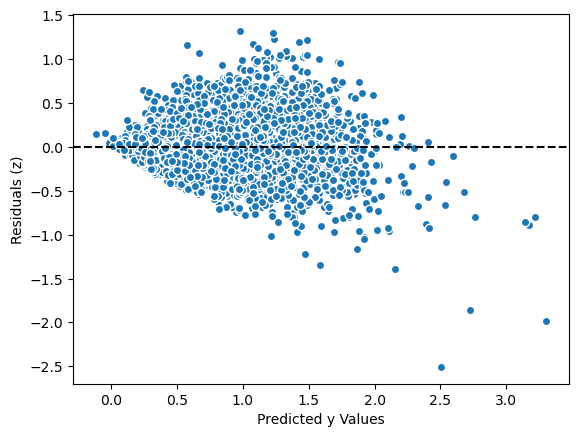

In [434]:
plt.plot(m1.predy, 
         m1.u, 
         'oC0',  
         markeredgecolor='white')
plt.axhline(linestyle = 'dashed', c = 'black')
plt.xlabel('Predicted y Values')
plt.ylabel('Residuals (z)') 
m1_moran = esda.moran.Moran(m1.u, w)
print(round(m1_moran.I,3))
print(round(m1_moran.p_sim,3))

In [457]:
variable_names = ['UNEMPL','HHDEN','POPDEN']
burg_lagm = spreg.ML_Lag(gdf[['log_BURGCASE']].values,
                  gdf[variable_names].values,
                  w=w,
                  name_y='log_BURGCASE',
                  name_x=variable_names)
print(burg_lagm.summary)

burg_lagm_moran = esda.moran.Moran(burg_lagm.u, w)
print(round(burg_lagm_moran.I,3))
print(round(burg_lagm_moran.p_sim,3))

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :log_BURGCASE                Number of Observations:        4659
Mean dependent var  :      0.8884                Number of Variables   :           5
S.D. dependent var  :      0.5154                Degrees of Freedom    :        4654
Pseudo R-squared    :      0.7332
Spatial Pseudo R-squared:  0.6590
Sigma-square ML     :       0.071                Log likelihood        :    -592.454
S.E of regression   :       0.266                Akaike info criterion :    1194.907
                                                 Schwarz criterion     :    1227.140

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

In [458]:
variable_name=['UNEMPL','HHDEN','POPDEN']

burg_errm = spreg.ML_Error(gdf[['log_BURGCASE']].values,
                  gdf[variable_name].values,
                  w=w,
                  name_y='log_BURGCASE',
                  name_x=variable_name)
print(burg_errm.summary)

burg_errm_moran = esda.moran.Moran(burg_errm.u, w)
print(round(burg_errm_moran.I,3))
print(round(burg_errm_moran.p_sim,3))

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = FULL)
-------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :log_BURGCASE                Number of Observations:        4659
Mean dependent var  :      0.8884                Number of Variables   :           4
S.D. dependent var  :      0.5154                Degrees of Freedom    :        4655
Pseudo R-squared    :      0.5956
Sigma-square ML     :       0.073                Log likelihood        :    -763.495
S.E of regression   :       0.270                Akaike info criterion :    1534.990
                                                 Schwarz criterion     :    1560.776

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------------------------------------

In [413]:
moran_i_value = round(moran.I,3)
moran_p_value = moran.p_sim
print(f"Moran's I value: {moran_i_value}")
print(f"Moran's I p_value: {moran_p_value}")

Moran's I value: 0.691
Moran's I p_value: 0.001


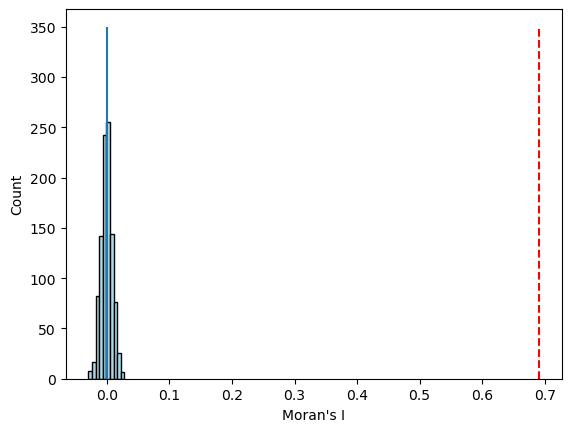

In [420]:
plt.hist(moran.sim, 10, facecolor='lightblue', edgecolor='black')
plt.vlines(moran.I, 0, 350, color='r', linestyle="--")
plt.vlines(moran.EI, 0, 350)
plt.xlabel("Moran's I")
plt.ylabel("Count")
plt.show()

## Bivariate Moran's I

In [318]:
from esda.moran import Moran_BV, Moran_Local_BV
from splot.esda import plot_moran_bv_simulation, plot_moran_bv
from esda.moran import Moran
from esda.moran import Moran_Local
from esda.moran import Moran_Local_BV
from splot.esda import plot_local_autocorrelation
from splot.esda import moran_scatterplot
from splot.esda import lisa_cluster

Bivariate Moran's I: -0.4267563821858183
P-value: 0.001


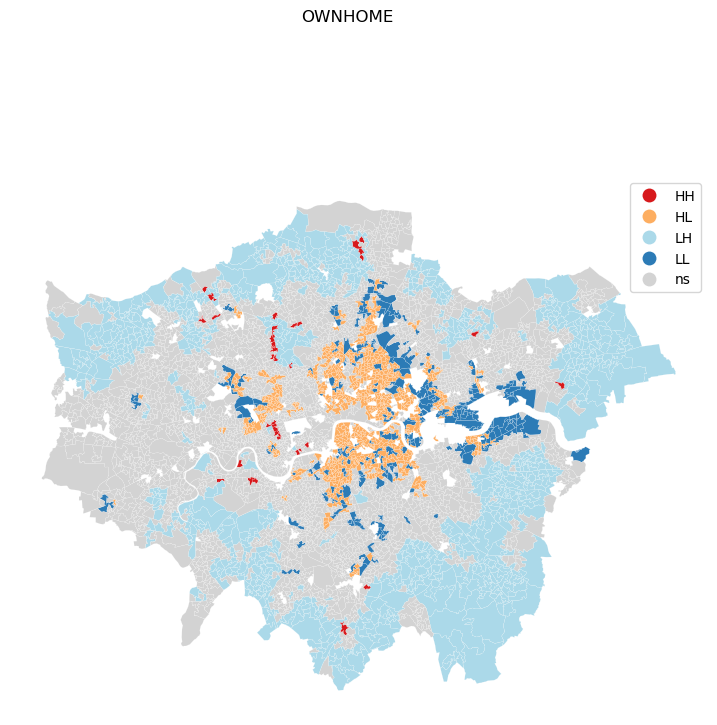

In [467]:

ind_var = 'OWNHOME'
y = gdf['BURGCASE'].values
x =  gdf[ind_var].values

moran = Moran(y,w)
moran_bv = Moran_BV(y, x, w)
moran_loc = Moran_Local(y, w)
moran_loc_bv = Moran_Local_BV(y, x, w)
bv_moran_i = moran_bv.I
bv_moran_i_p = moran_bv.p_sim
print(f"Bivariate Moran's I: {bv_moran_i}")
print(f"P-value: {bv_moran_i_p}")

lisa_cluster(moran_loc_bv, gdf, p=0.05, figsize = (9,9))
plt.suptitle(ind_var)
plt.savefig('figures/3_bvmoran_POPDEN',dpi=300,bbox_inches='tight',facecolor='white')
plt.show()

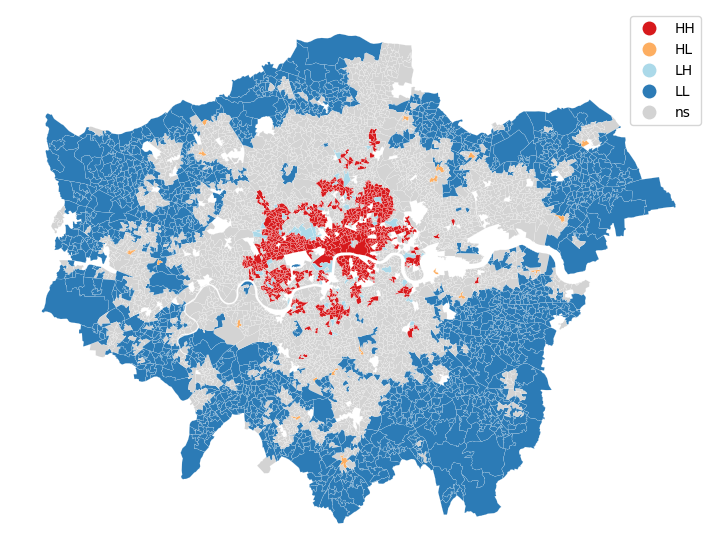

In [477]:
moran_loc = Moran_Local(y, w)
lisa_cluster(moran_loc, gdf, p=0.05, figsize = (9,9))
plt.savefig('figures/2_LISA_burglary',dpi=300,bbox_inches='tight',facecolor='white')
plt.show()

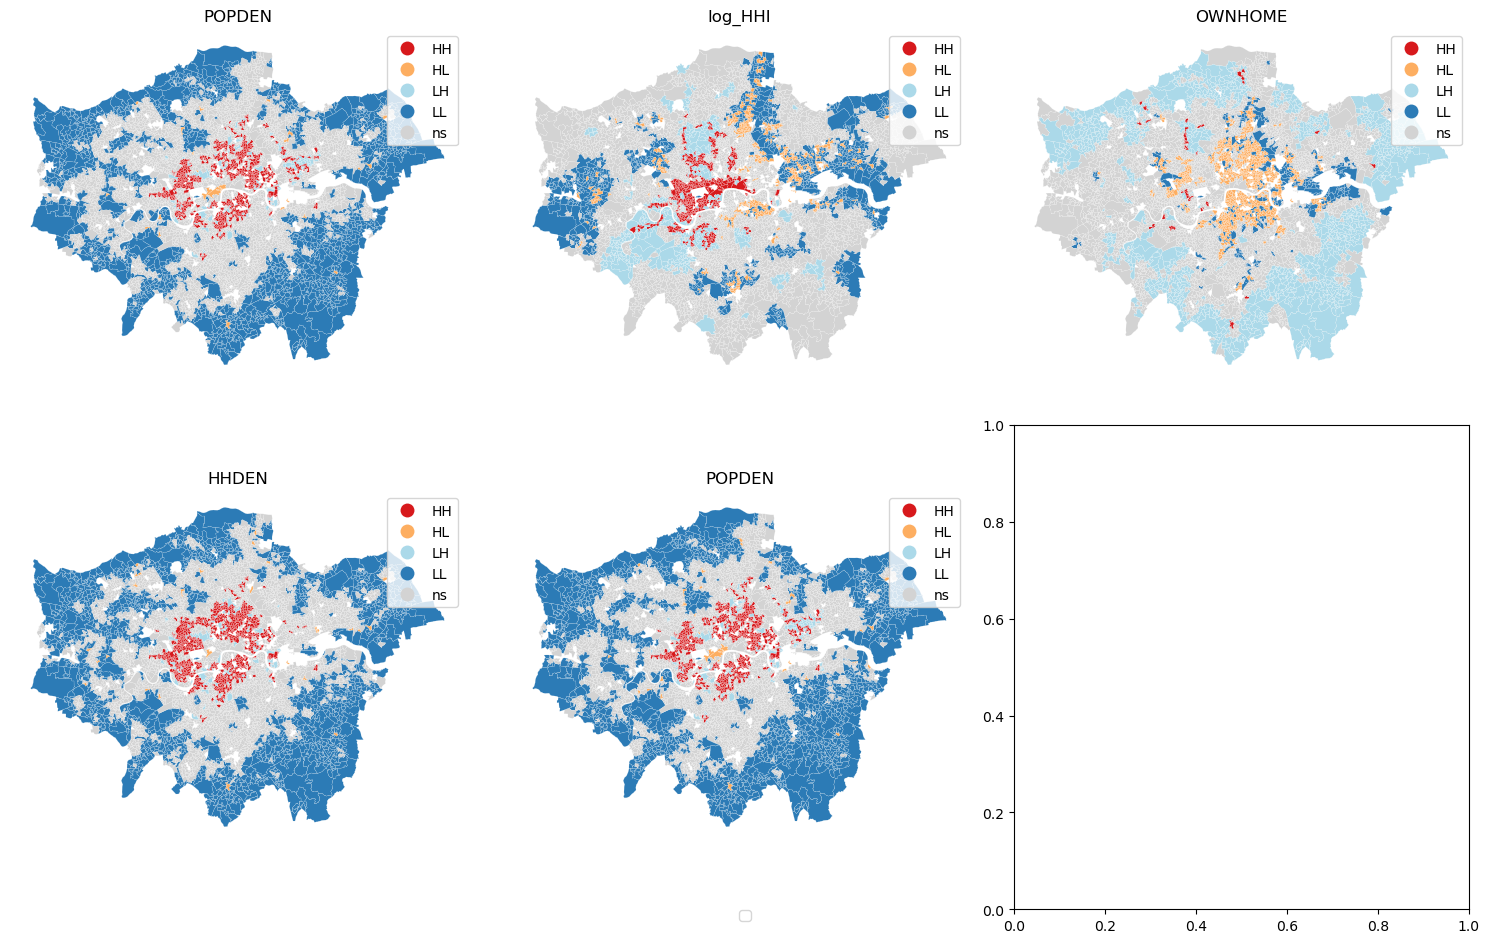

In [415]:
ind_vars = ['POPDEN', 'log_HHI', 'OWNHOME', 'HHDEN', 'POPDEN']  # Replace with your variable names
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Adjust rows and columns based on your preference

for i, ind_var in enumerate(ind_vars):
    y = gdf['BURGCASE'].values
    x = gdf[ind_var].values

    moran_loc_bv = Moran_Local_BV(y, x, w)
    
    # Plot LISA cluster maps
    ax = axes[i // 3, i % 3]
    lisa_cluster(moran_loc_bv, gdf, p=0.05, figsize=(9, 9), ax=ax)
    ax.set_title(ind_var)

# Adjust layout
plt.tight_layout()

# Create a common legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.02), ncol=len(ind_vars))
plt.show()

### Figure Highlighting LSOA Island

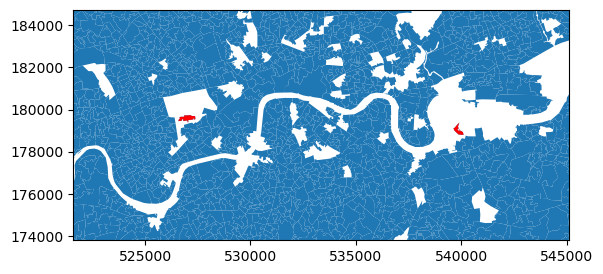

In [242]:
highlight_indices = [4477, 4617]

# Plot the entire GeoDataFrame
gdf.plot()

# Highlight specific indices
highlighted_points = gdf.loc[highlight_indices]
highlighted_points.plot(marker='o', color='red', markersize=50, ax=plt.gca())
highlighted_bbox = highlighted_points.total_bounds

# Set axis limits to zoom in on the highlighted points
plt.xlim((highlighted_bbox[0] - 5000, highlighted_bbox[2] +5000))
plt.ylim((highlighted_bbox[1] - 5000, highlighted_bbox[3] + 5000))


# Show the plot
plt.show()

## Spatial Distirbution of Variables

### Choropleth Maps

In [76]:
import palettable.colorbrewer.sequential as pcs
gdf = gdf.set_crs(epsg= 27700)

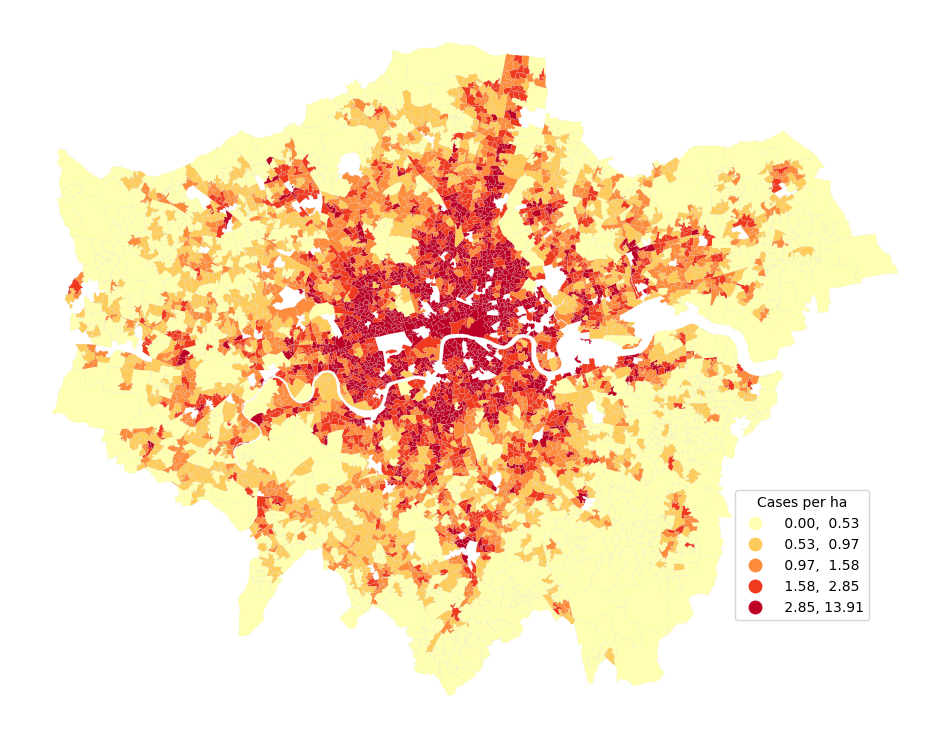

In [361]:
f, ax = plt.subplots(1,figsize=(12,10))
gdf.plot(column='BURGCASE',legend = True, scheme = "Quantiles",
        ax=ax, cmap = pcs.YlOrRd_5.mpl_colormap,legend_kwds={'title':'Cases per ha','loc':(0.78,0.15)},edgecolor='lightgrey',linewidth=0.08)
ax.set_axis_off()
plt.savefig('figures/1_spatial_burglary_map',dpi=300,bbox_inches='tight',facecolor='white')
plt.show()

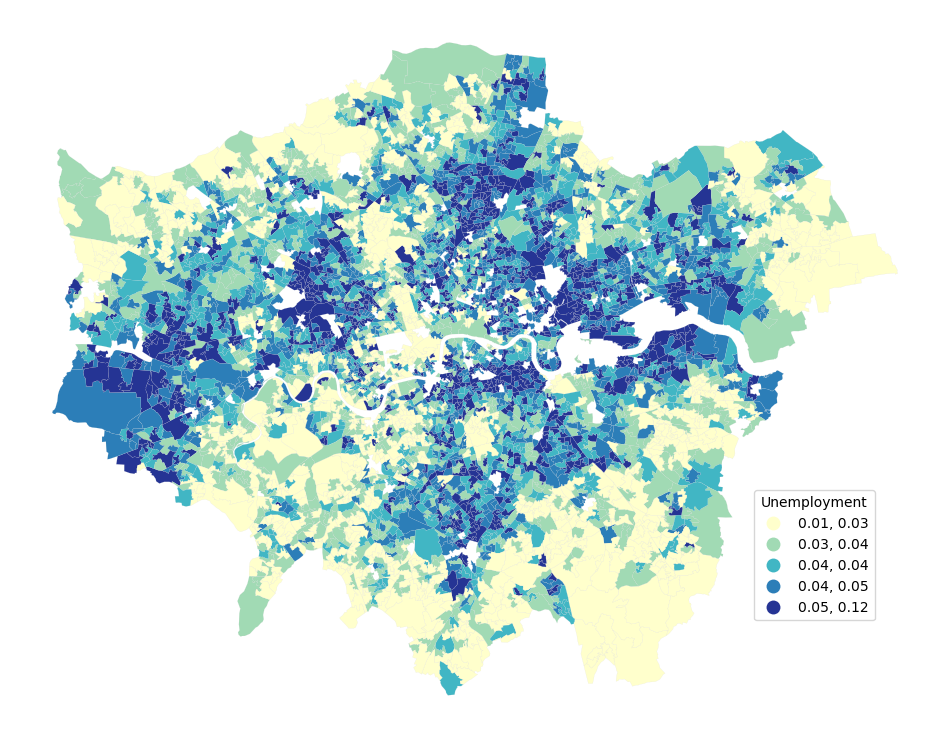

In [79]:
f, ax = plt.subplots(1,figsize=(12,10))
gdf.plot(column='UNEMPL',legend = True, scheme = "Quantiles",
        ax=ax, cmap = pcs.YlGnBu_5.mpl_colormap,legend_kwds={'title':'Unemployment','loc':(0.8,0.15)},edgecolor='lightgrey',linewidth=0.08)
ax.set_axis_off()
plt.savefig('figures/1_unemploy_map',dpi=300,bbox_inches='tight',facecolor='white')
plt.show()

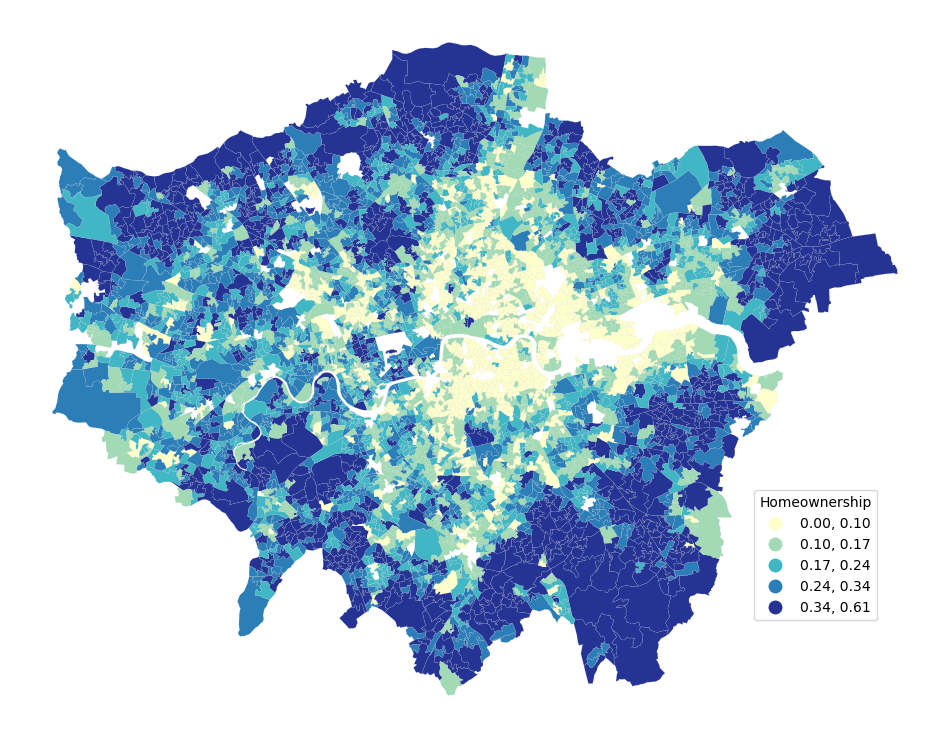

In [84]:
f, ax = plt.subplots(1,figsize=(12,10))
gdf.plot(column='OWNHOME',legend = True, scheme = "Quantiles",
        ax=ax, cmap = pcs.YlGnBu_5.mpl_colormap,legend_kwds={'title':'Homeownership','loc':(0.8,0.15)},edgecolor='lightgrey',linewidth=0.08)
ax.set_axis_off()
plt.savefig('figures/1_Ownhome_map',dpi=300,bbox_inches='tight',facecolor='white')
plt.show()

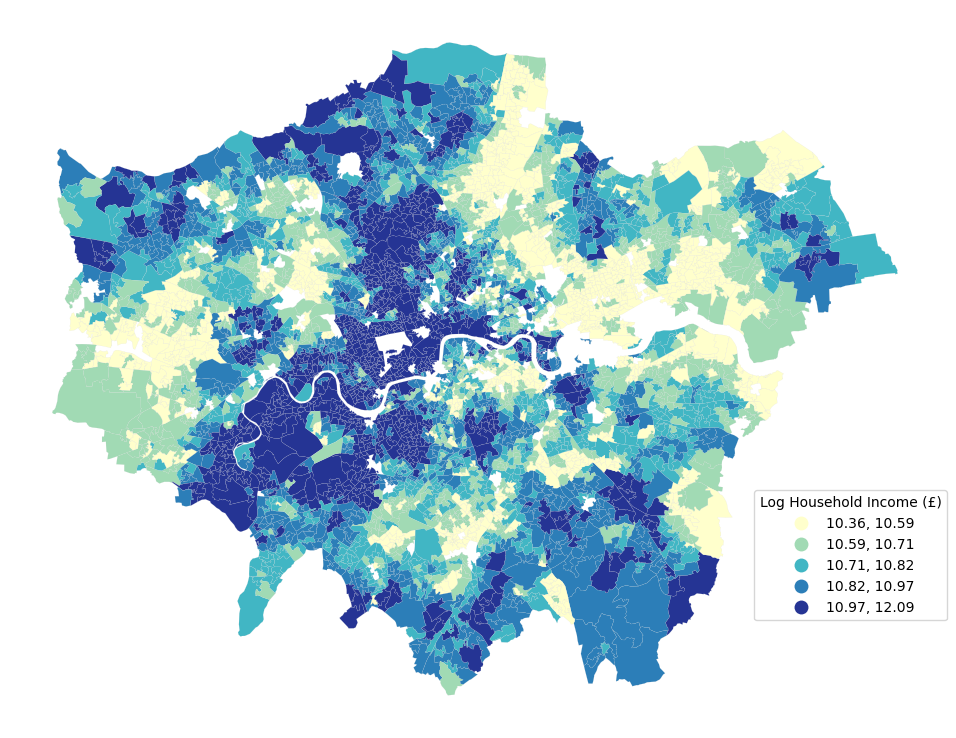

In [479]:
f, ax = plt.subplots(1,figsize=(12,10))
gdf.plot(column='log_HHI',legend = True, scheme = "Quantiles",
        ax=ax, cmap = pcs.YlGnBu_5.mpl_colormap,legend_kwds={'title':'Log Household Income (£)','loc':(0.8,0.15)},edgecolor='lightgrey',linewidth=0.08)
ax.set_axis_off()
plt.savefig('figures/1_HHI_map',dpi=300,bbox_inches='tight',facecolor='white')
plt.show()

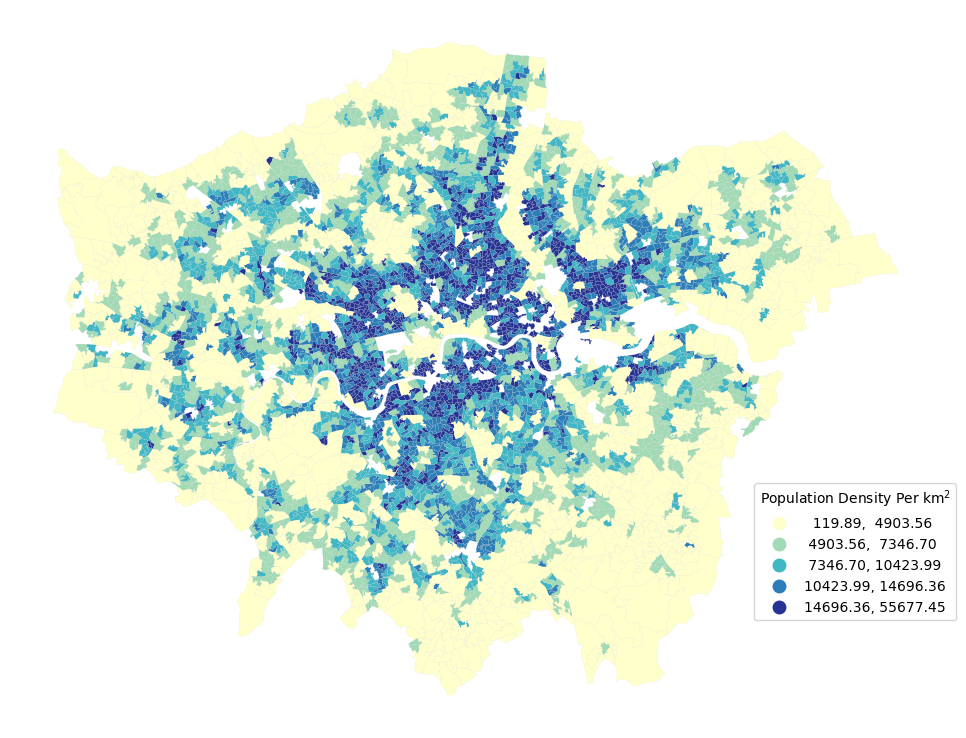

In [87]:
f, ax = plt.subplots(1,figsize=(12,10))
gdf.plot(column='POPDEN',legend = True, scheme = "Quantiles",
        ax=ax, cmap = pcs.YlGnBu_5.mpl_colormap,legend_kwds={'title':'Population Density Per km$^2$','loc':(0.8,0.15)},edgecolor='lightgrey',linewidth=0.08)
ax.set_axis_off()
plt.savefig('figures/1_popden_map',dpi=300,bbox_inches='tight',facecolor='white')
plt.show()

In [ ]:
f, ax = plt.subplots(1,figsize=(12,10))
gdf.plot(column='HHDEN',legend = True, scheme = "Quantiles",
        ax=ax, cmap = pcs.YlGnBu_5.mpl_colormap,legend_kwds={'title':'Household Density Per ha','loc':(0.8,0.15)},edgecolor='lightgrey',linewidth=0.08)
ax.set_axis_off()
plt.savefig('figures/1_HHDEN_map',dpi=300,bbox_inches='tight',facecolor='white')
plt.show()

# Plot And Transform Varaibles

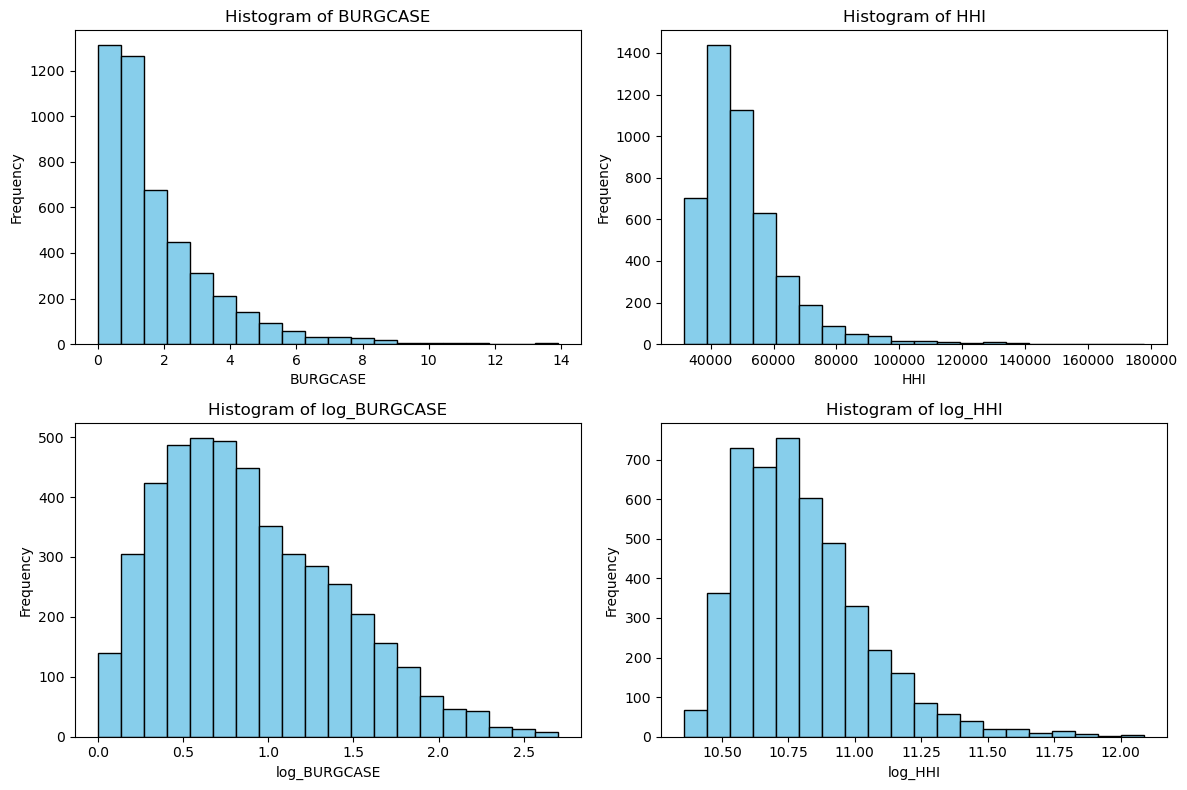

In [409]:
variables_to_plot = ['BURGCASE','HHI','log_BURGCASE','log_HHI']# Replace with your variable names

# Set up subplots
num_variables = len(variables_to_plot)
num_rows = (num_variables // 2) + (num_variables % 2)
fig, axs = plt.subplots(num_rows, 2, figsize=(12, num_rows * 4))

# Flatten the axs array if only one row
axs = axs.flatten() if num_rows > 1 else axs

# Loop through variables and create histograms
for i, variable in enumerate(variables_to_plot):
    ax = axs[i]
    
    # Extract values from the GeoDataFrame
    values = gdf[variable].dropna().values
    
    # Create histogram
    ax.hist(values, bins=20, color='skyblue', edgecolor='black')
    
    # Set plot labels and title
    ax.set_title(f'Histogram of {variable}')
    ax.set_xlabel(variable)
    ax.set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

In [403]:

gdf['log_HHI'] = np.log(gdf['HHI']+1)

gdf['log_BURGCASE'] =  np.log(gdf['BURGCASE']+1)

In [407]:
gdf['HHDEN'].skew()

1.5927801834708242